/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_2789/3028244510.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


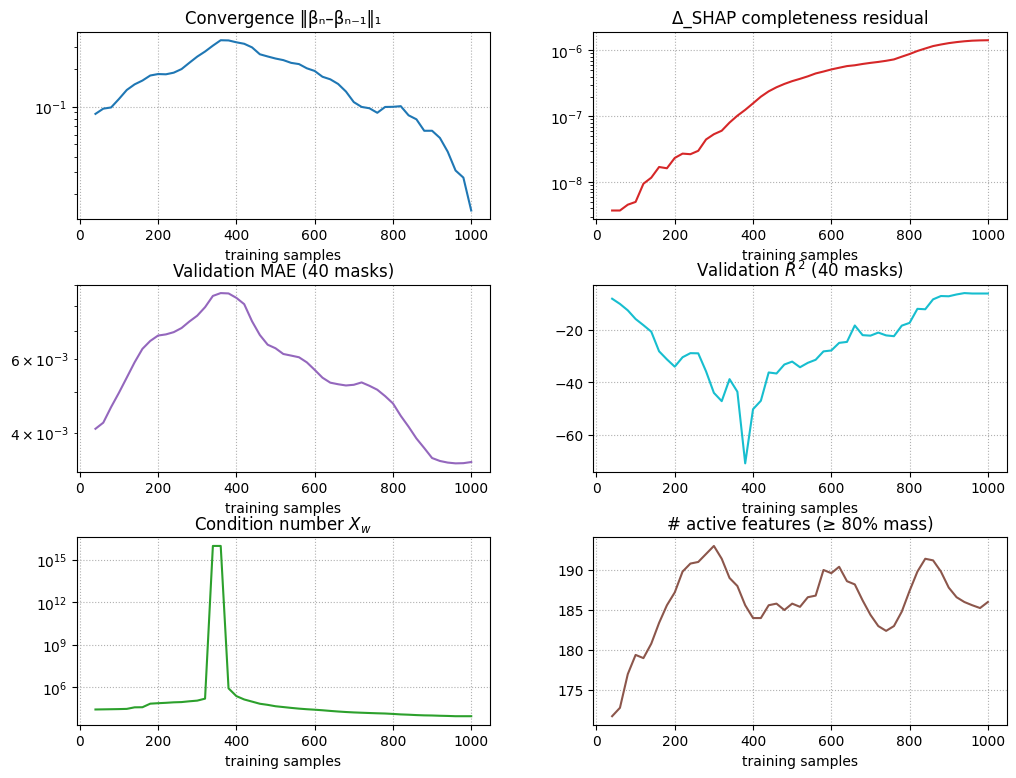

In [1]:
#!/usr/bin/env python3
# ---------------------------------------  KernelSHAP convergence dashboard (single patient)
import numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader
from my_load import CPU_Unpickler
from numpy.random import default_rng
import matplotlib.gridspec as gridspec

# ------------------------------ 1. CONFIG ---------------------------------
ROOT_DIR      = Path("../output")                        
DATASET_PATH  = "00039/dataset-OA-1000.pkl"            # <-- seleziona qui il paziente
VAL_ROWS      = 40                                       
CHECKPOINTS   = np.arange(20, 1000+1, 20)                
RNG           = default_rng(0)                           
FRAC_TARGET   = 0.8                                      

# ------------------------------ 2. HELPERS --------------------------------
def active_count(abs_coefs: np.ndarray, frac: float = 0.95) -> int:
    total = abs_coefs.sum()
    if total == 0:  
        return 0
    sorted_abs = np.sort(abs_coefs)[::-1]
    cum = np.cumsum(sorted_abs)
    return int((cum < frac * total).sum() + 1)

def calculate_r2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0

# ------------------------------ 3. LOAD DATA ------------------------------
pkl_path = ROOT_DIR / DATASET_PATH

with open(pkl_path, "rb") as f:
    ds = CPU_Unpickler(f).load()
if isinstance(ds, DataLoader):
    ds = ds.dataset
X, y, w = (t.cpu() for t in ds.tensors)
f_x = y[0].item()

# split fixed validation rows
idx_all   = np.arange(X.shape[0])
val_idx   = RNG.choice(idx_all, size=VAL_ROWS, replace=False)
train_idx = np.setdiff1d(idx_all, val_idx, assume_unique=True)
X_val, y_val = X[val_idx].numpy(), y[val_idx].numpy()

# ------------------------------ 4. LOOP CHECKPOINTS -----------------------
beta_prev = None
conv_L1, delta, val_mae, val_r2, nz_feat, cond_num = [], [], [], [], [], []
coefs_list = []

for n in CHECKPOINTS:
    n_train = min(n, len(train_idx))
    idx_sub = train_idx[:n_train]
    X_b, y_b, w_b = X[idx_sub].numpy(), y[idx_sub].numpy(), w[idx_sub].numpy()
    reg = LinearRegression()
    reg.fit(X_b, y_b, sample_weight=w_b)

    beta = torch.as_tensor(np.concatenate([[reg.intercept_], reg.coef_]),
                           dtype=torch.float32)
    coefs_list.append(reg.coef_)

    if beta_prev is not None:
        conv_L1.append(float(torch.norm(beta - beta_prev, p=1)))
    beta_prev = beta.clone()

    delta.append(abs(f_x - beta.sum().item()))
    y_pred_val = reg.intercept_ + X_val @ reg.coef_
    val_mae.append(float(np.abs(y_val - y_pred_val).mean()))
    val_r2.append(calculate_r2(y_val, y_pred_val))

    Wsqrt = np.sqrt(w_b).reshape(-1,1)
    Xw    = np.column_stack([np.ones(n_train), X_b]) * Wsqrt
    try:
        svals = np.linalg.svd(Xw, full_matrices=False)[1]
        cond_num.append(svals[0] / svals[-1])
    except np.linalg.LinAlgError:
        cond_num.append(np.inf)

# sparsity
nz_feat = [active_count(np.abs(c), FRAC_TARGET) for c in coefs_list]

# ------------------------- helper: smoothing ------------------------------
def smooth(arr: np.ndarray, win: int = 5) -> np.ndarray:
    pad = win // 2
    sm  = np.empty_like(arr, dtype=float)
    for i in range(len(arr)):
        lo, hi = max(0, i - pad), min(len(arr), i + pad + 1)
        sm[i] = arr[lo:hi].mean()
    return sm

conv_L1  = smooth(np.array(conv_L1))
delta    = smooth(np.array(delta))
val_mae  = smooth(np.array(val_mae))
nz_feat  = smooth(np.array(nz_feat))

# ------------------------------ 5. PLOT -----------------------------------
x_conv = CHECKPOINTS[1:]  # conv/delta start at 2nd cp

fig = plt.figure(figsize=(12,9))
gs  = gridspec.GridSpec(3,2, hspace=0.35, wspace=0.25)
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(2)]

# Row-1
axes[0].plot(x_conv, conv_L1, color='tab:blue')
axes[0].set_yscale('log'); axes[0].set_title('Convergence ‖βₙ–βₙ₋₁‖₁'); axes[0].grid(ls=':')

axes[1].plot(x_conv, delta[1:], color='tab:red')
axes[1].set_yscale('log'); axes[1].set_title('Δ_SHAP completeness residual'); axes[1].grid(ls=':')

# Row-2
axes[2].plot(x_conv, val_mae[1:], color='tab:purple')
axes[2].set_yscale('log'); axes[2].set_title('Validation MAE (40 masks)'); axes[2].grid(ls=':')

axes[3].plot(x_conv, val_r2[1:], color='tab:cyan')
axes[3].set_title(f'Validation $R^2$ ({VAL_ROWS} masks)'); axes[3].grid(ls=':')

# Row-3
axes[4].plot(x_conv, cond_num[1:], color='tab:green')
axes[4].set_yscale('log'); axes[4].set_title('Condition number $X_w$'); axes[4].grid(ls=':')

axes[5].plot(x_conv, nz_feat[1:], color='tab:brown')
axes[5].set_title(f'# active features (≥ {FRAC_TARGET * 100:.0f}% mass)'); axes[5].grid(ls=':')

for ax in axes:
    ax.set_xlabel('training samples')

fig.tight_layout()
plt.show()